# Example of Kernel Shap w/ Uncertainty

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np

from scipy import ndimage
from copy import deepcopy

import pandas as pd

import sys
sys.path.append("../..")
import shap

# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()
model = VGG16()

# load an image
file = "data/apple_strawberry.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)

NSEGMENTS = 50
# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=NSEGMENTS, compactness=30, sigma=3)

Using TensorFlow backend.


In [2]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [5]:
explainer = shap.ProbKernelExplainer(f, np.zeros((1,NSEGMENTS)))
shap_values, shap_vars, calc_r = explainer.shap_values(np.ones((1,NSEGMENTS)), nsamples=100, l1_reg="bic") # runs VGG16 1000 times

In [9]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [10]:
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

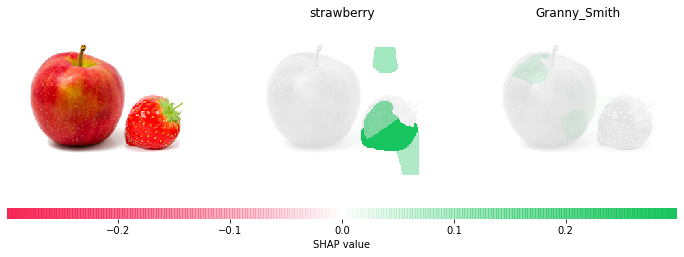

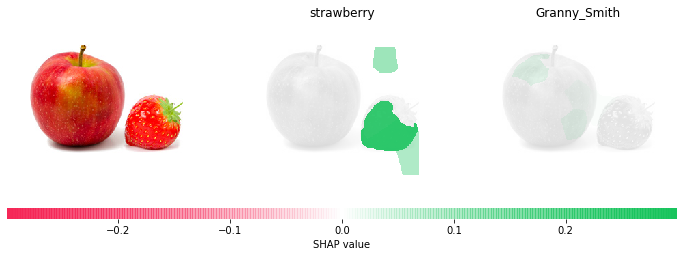

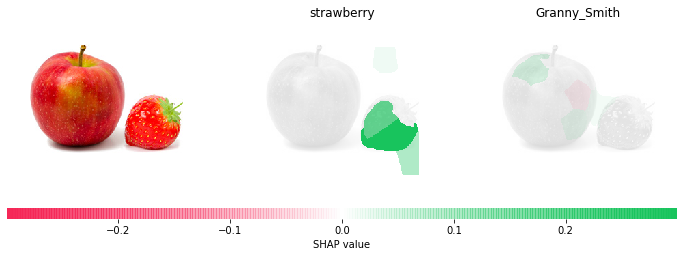

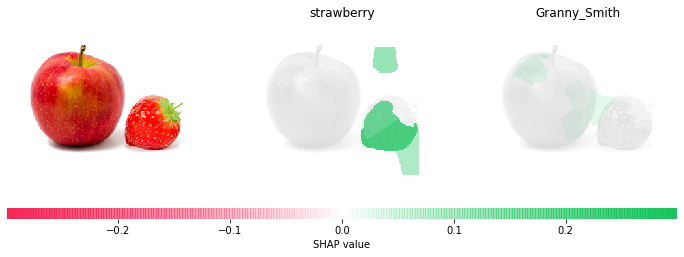

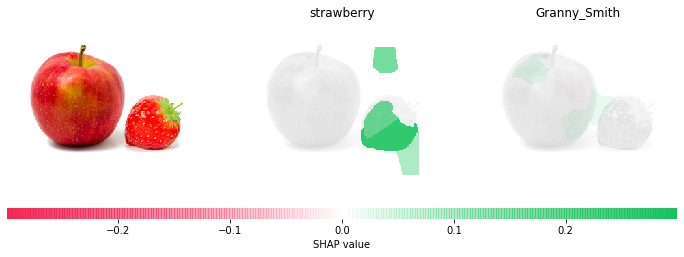

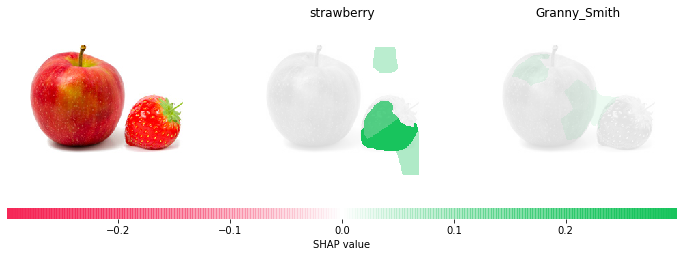

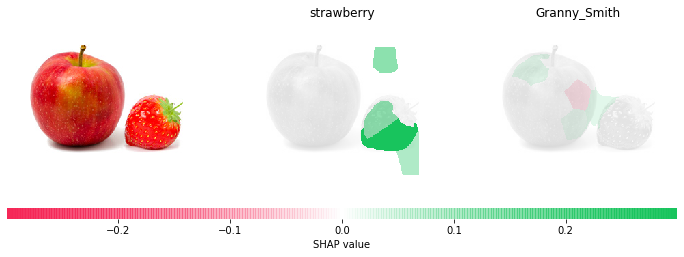

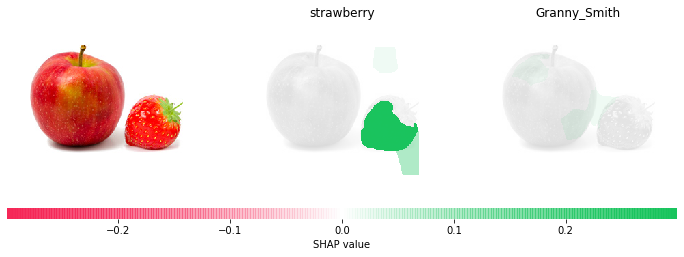

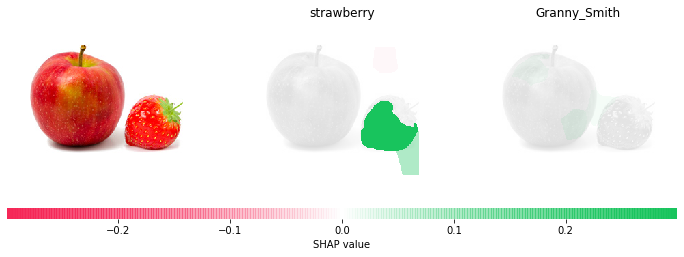

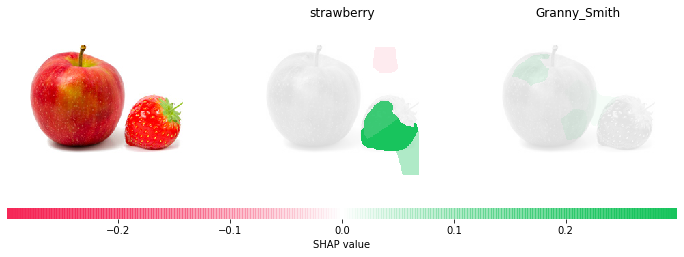

In [12]:
from numpy.random import multivariate_normal

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
for ex in range(10):
    fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(12,4))
    inds = top_preds[0]
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(2):
        shap_means = shap_values[inds[i]][0]
        shap_variance = shap_vars[inds[i]]
        axes[i+1].set_title(feature_names[str(inds[i])][1])
        m = fill_segmentation(multivariate_normal(shap_means, shap_variance), segments_slic)
        axes[i+1].imshow(img.convert('LA'), alpha=0.15)
        im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i+1].axis('off')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    pl.savefig("results/fig_{}".format(ex))